## Import

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyedflib import highlevel
from scipy.io import loadmat
from scipy.signal import butter, sosfilt, sosfiltfilt, sosfreqz
from scipy.signal import freqz, iirnotch, filtfilt
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from scipy.fftpack import fft, fftfreq, rfft, rfftfreq
from imblearn.over_sampling import SMOTE
from scipy.signal import resample

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator

class CustomTranformer(TransformerMixin, BaseEstimator): 
    # BaseEstimator generates the get_params() and set_params() methods that all Pipelines require
    # TransformerMixin creates the fit_transform() method from fit() and transform()
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.means = X.mean()
        return self
    
    def transform(self, X, y=None):
        norm_features = X - self.means
        return norm_features

### Read edf files

In [3]:
# dict_signals = {}
# dict_signals_headers = {}
# files_list = list(range(1,60))
# files_list.remove(4)
# files_list.remove(29)
# for i in files_list:
#     signals, signal_headers, header = highlevel.read_edf(f'/home/lee/code/mariaaraujovitoria/SeizurePredict/raw_data/eeg{str(i)}.edf')
#     dict_signals[f"eeg{str(i)}"] = signals
#     dict_signals_headers[f"eeg{str(i)}"] = signal_headers

## variables

In [19]:
n = 5
sample_rate = 256
path_annt = '../raw_data/annotations_2017.mat'
path_eeg = f'../raw_data/eeg{n}.edf'
sec = 10
len_window = sample_rate*sec
scaler = CustomTranformer()

## Functions

In [20]:
# Load the data 
signals, signal_headers, header = highlevel.read_edf(path_eeg)
names_ele = [signal_headers[iele]['label'] for iele in range(signals.shape[0])]

# Highpass filter
def highpass_filter(signals, sample_rate=256, hp_frequency = 0.1):
    sos = butter(N = 3, Wn = hp_frequency, btype="highpass",fs=sample_rate, output="sos")
    filter_hp = sosfiltfilt(sos, signals)
    return filter_hp

# Powerline filter
def notch_filter(signals, sampling_rate, notch_frequency = 50, quality_factor = 30):
    w0 = notch_frequency/(sampling_rate/2)
    b_notch, a_notch = iirnotch(w0, quality_factor)
    filter_notch = filtfilt(b_notch, a_notch, signals, axis = -1)
    return filter_notch

# fourier transform
def fourier_transform(signals, sampling_rate=256):
    if np.ndim(signals) == 1:
        y = abs(rfft(signals))
        N = len(signals)
    else:
        y = np.array([abs(rfft(signals[i])) for i in range(len(signals))])
        N = len(signals[0])
    xf = fftfreq(N, 1 / sampling_rate)
    return (xf,y)

In [24]:
# Combination of all filters and Scaler
def filter_signals(signals, scaler, sample_rate=256, hp_frequency = 0.1, notch_frequency = 50, quality_factor = 30):
    filter_hp = highpass_filter(signals, sample_rate)
    filter_notch = notch_filter(signals, sample_rate, notch_frequency, quality_factor)
    final_signal = scaler.fit_transform(filter_notch)
    return final_signal

In [25]:
# Combination of all filters and fft (power domain)
def filter_fourier(signals, scaler, sample_rate=256, hp_frequency = 0.1, notch_frequency = 50, quality_factor = 30):
        filtered = filter_signals(signals, scaler, sample_rate, hp_frequency, notch_frequency, quality_factor)
        xf,y = fourier_transform(filtered, sample_rate)
        return y

In [26]:
# Create target based on samples
def create_target(path_annt, n, sample_rate = 256):
    annt = loadmat(path_annt)
    target = annt['annotat_new'][0][n-1].sum(axis=0)
    target[target == 1] = 0
    target[target > 1] =1
    sample_target = []
    for num in target:
        for i in range(sample_rate):
            sample_target.append(num)
    return sample_target

In [27]:
def concat_target(filtered_signals, target, names_ele):
    signals = filtered_signals.T
    signals_df = pd.DataFrame(signals,columns=names_ele)
    signals_df["target"]=target
    if (not 'Resp Effort' in signals_df.columns) and (not 'ECG EKG' in signals_df.columns):
        signals_df.rename(columns = {'ECG EKG-REF':'ECG EKG','Resp Effort-REF':'Resp Effort'}, inplace=True)
    signals_df.drop(columns=['Resp Effort', 'ECG EKG'], inplace=True)
    return signals_df

In [40]:
threshold = 2*sample_rate

In [38]:
def flatten_window(window_df):
    if len(np.unique(window_df.iloc[:,-1])) == 1:
        target = window_df.iloc[0,-1]
    elif np.unique(window_df.iloc[:,-1],return_counts=True)[1][1] >= threshold:
        target = 1
    else:
        target = 0
    t_df = window_df.drop(columns = "target").transpose()
    flatten = pd.DataFrame(np.array(t_df).reshape(1,t_df.shape[0]*t_df.shape[1]))
    flatten["Target"] = target
    return flatten

In [ ]:
df = np.array([flatten_window(signals_df.iloc[i:i+len_window+1]) for i in range(0,len(signals_df)-len_window, 5*256)])

r=df.shape[0]
c=df.shape[2]

df = pd.DataFrame(df.reshape(r,c))

## Oversampling

In [21]:
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = df.columns

NameError: name 'X_train' is not defined

## create data

In [14]:
num = list(np.arange(1,80))
num.remove(4)
num.remove(29)
num.remove(50)
# num.remove(9)
num

[1,
 2,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79]

In [17]:
for n in num[0:10]:
    print(n)
    path_eeg = f'../raw_data/eeg{n}.edf'
    signals, signal_headers, header = highlevel.read_edf(path_eeg)
    names_ele = [signal_headers[iele]['label'] for iele in range(signals.shape[0])]
    target = create_target(path_annt, n)
    filtered_signals = filter_fourier(signals, scaler)
    signals_df = concat_target(filtered_signals, target, names_ele)
    df = np.array([flatten_window(signals_df.iloc[i:i+len_window+1]) for i in range(0,len(signals_df)-len_window, 5*256)])
    r=df.shape[0]
    c=df.shape[2]
#     df = df.reshape(r,c)
    df = pd.DataFrame(df.reshape(r,c))
    with open('df.csv', 'a') as file:
        np.savetxt(file, df, delimiter=",") 

1
2
3
5
6


KeyboardInterrupt: 

## model

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score

In [82]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

**logistic**

In [166]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [167]:
model.score(X_test,y_test)

0.8246753246753247

In [161]:
score_lr = cross_val_score(model, X_train, y_train, scoring = "recall", cv = 5)

In [163]:
score_lr.mean()

0.9342419716206123

In [168]:
y_pred = model.predict(X_test)

In [169]:
recall_score(y_test, y_pred)

0.9548872180451128

In [176]:
precision_score(y_test, y_pred)

0.8581081081081081

**knn**

In [172]:
model2 = KNeighborsClassifier(n_neighbors=5)

In [173]:
model2.fit(X_train, y_train)

KNeighborsClassifier()

In [174]:
model2.score(X_test, y_test)

0.8181818181818182

**svc**

In [177]:
model3 = SVC()

In [178]:
model3.fit(X_train, y_train)

SVC()

In [179]:
model3.score(X_test, y_test)

0.8636363636363636

## baseline

In [180]:
baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_train, y_train)
baseline_model.score(X_test, y_test)

0.8636363636363636

## balanced model

### under

In [185]:
shuffled_df = df.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
df_0 = shuffled_df.loc[shuffled_df.iloc[:,-1] == 0]

#Randomly select 492 observations from the non-fraud (majority class)
df_1 = shuffled_df.loc[shuffled_df.iloc[:,-1] == 1].sample(n=171,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([df_1, df_0])

In [186]:
normalized_df

,0,1,2,3,4,5,6,7,8,9,...,48650,48651,48652,48653,48654,48655,48656,48657,48658,48659
126,0.159359,0.168830,0.199304,0.189241,0.282816,0.245389,0.151429,0.166411,0.164438,0.165532,...,0.444626,0.521216,0.407028,0.326486,0.322318,0.403674,0.496608,0.493917,0.383777,1.0
468,0.315043,0.422249,0.556405,0.451055,0.397534,0.495360,0.837258,1.000000,0.848685,0.820578,...,0.426337,0.480585,0.558416,0.718833,0.845160,0.820545,0.851344,0.839022,0.868716,1.0
577,0.966589,0.966854,0.973309,0.989355,0.980668,0.981222,0.954036,0.961885,0.963690,0.962414,...,0.780843,0.811155,0.859953,0.839005,0.766131,0.864346,0.997214,1.000000,0.860356,1.0
441,0.506537,0.564580,0.592215,0.609836,0.619982,0.637050,0.665652,0.670184,0.684146,0.691446,...,0.550362,0.553410,0.541158,0.510429,0.493999,0.496369,0.471623,0.454837,0.447198,1.0
686,0.630122,0.747886,0.807355,0.787173,0.754615,0.672211,0.495624,0.418795,0.355425,0.303075,...,0.432501,0.428051,0.428349,0.434048,0.422386,0.419671,0.407860,0.404890,0.385659,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0.167371,0.166063,0.176750,0.167862,0.175929,0.515659,0.657915,0.584345,0.175352,0.172414,...,0.088976,0.095882,0.096542,0.092560,0.091529,0.116108,0.106577,0.093288,0.096843,0.0
183,0.965955,0.951364,0.956597,0.948905,0.958147,0.951920,0.952823,0.968658,0.953744,0.950233,...,0.458460,0.472705,0.485776,0.497862,0.509062,0.516747,0.514312,0.502225,0.505926,0.0
294,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.970093,0.931957,0.966693,0.969149,...,0.629877,0.616500,0.640236,0.618304,0.564735,0.628651,0.678015,0.627074,0.649295,0.0
44,0.643906,0.815330,0.896351,0.793755,0.620158,0.617346,0.769302,0.780412,0.709104,0.558077,...,0.240313,0.502492,0.873653,0.930146,0.929608,0.890153,0.710859,0.623848,0.621266,0.0


In [188]:
X_balanced = normalized_df.iloc[:,:-1]
y_balanced = normalized_df.iloc[:,-1]

In [189]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_balanced,y_balanced, test_size=0.2)

In [192]:
model4 = LogisticRegression(max_iter=1000)

In [193]:
model4.fit(X_train_b,y_train_b)

LogisticRegression(max_iter=1000)

In [194]:
model4.score(X_test_b, y_test_b)

0.5172413793103449

In [195]:
model5 = SVC()

In [196]:
model5.fit(X_train_b,y_train_b)

SVC()

In [197]:
model5.score(X_test_b, y_test_b)

0.5344827586206896

In [198]:
model6=KNeighborsClassifier()

In [199]:
model6.fit(X_train_b,y_train_b)

KNeighborsClassifier()

In [200]:
model6.score(X_test_b, y_test_b)

0.5689655172413793

In [202]:
y6 = model6.predict(X_test_b)

In [203]:
recall_score(y_test_b, y6)

0.36666666666666664

In [201]:
baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_train_b, y_train_b)
baseline_model.score(X_test_b, y_test_b)

0.5172413793103449

### over

In [84]:
from imblearn.over_sampling import SMOTE

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = df.columns

In [85]:
oversampled_trainX

,0,1,2,3,4,5,6,7,8,9,...,48649,48650,48651,48652,48653,48654,48655,48656,48657,48658
0,193.176266,2686.181899,1996.764909,2118.418608,1826.991330,1680.282926,3508.336513,535.545434,2825.465772,3792.339667,...,358.828358,783.630590,414.687849,1127.954887,517.757540,196.782641,617.632175,227.557558,589.557452,426.816025
1,2173.551811,1675.307258,761.304132,1646.762816,1115.060088,1200.202330,1784.223869,893.800042,1096.030010,278.552663,...,660.936592,149.459110,478.894215,461.798643,463.041128,472.146496,423.461511,176.796988,434.471621,417.506073
2,3468.525976,2583.818016,3868.946596,1185.168312,1873.815161,455.283198,2499.691376,1942.226932,1964.140056,1882.294127,...,556.879265,361.237333,742.643962,900.605679,328.159982,865.022462,233.824058,164.688119,436.770877,993.112095
3,1757.749326,555.038546,576.529336,4137.794451,2703.996088,784.866735,3178.712850,3838.756628,4659.648832,2864.902976,...,997.729287,531.129040,673.096303,575.369930,821.834016,813.966516,1140.468871,580.214812,730.943214,788.662329
4,2565.052583,673.357813,1890.285157,1005.263202,1505.499236,2094.020086,345.417070,2232.734304,1221.677019,691.788416,...,328.608434,160.560268,584.461009,691.778852,329.214005,368.933391,648.777254,481.238188,227.535457,251.642762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,12155.470066,7841.781857,5361.711177,22312.601007,12854.386719,13781.935440,18176.831373,6238.075077,27116.309460,6479.342310,...,17563.300436,4017.464214,14306.787871,9219.579672,18160.053552,26156.396760,16816.504474,5955.818394,9918.089873,17824.507043
1034,3739.951013,4481.338679,3663.294887,3362.595787,2462.174575,2910.808832,4033.449468,1671.703184,3975.766941,1602.706908,...,445.091856,896.695389,1027.289793,348.222195,1162.095372,953.419146,759.145781,1015.837614,1015.741341,1367.754114
1035,2897.435238,1912.736592,2827.266267,4760.616956,2177.603804,5824.467188,2530.843238,2905.318409,5083.519480,2596.058314,...,816.169127,747.199064,655.644200,904.099963,535.797210,983.079940,1125.003619,620.777458,469.820315,510.937936
1036,4456.256822,851.618968,3286.773733,1443.678333,3235.982043,3523.759968,2717.016680,4054.120138,3305.518132,3714.920147,...,308.456908,1251.094048,820.517782,247.588947,884.606159,645.903950,387.671093,390.711060,806.330069,472.660219


In [101]:
scaler_2 = MinMaxScaler()
scaler_2.fit(oversampled_trainX)

MinMaxScaler()

In [102]:
X_train_scaled = scaler_2.transform(oversampled_trainX)

In [103]:
X_train_scaled

array([[0.00032583, 0.01019532, 0.00685976, ..., 0.00087603, 0.00367628,
        0.00198615],
       [0.00438787, 0.00634886, 0.0025547 , ..., 0.00067688, 0.00270273,
        0.00194232],
       [0.00704405, 0.00980581, 0.01338353, ..., 0.00062937, 0.00271716,
        0.00465245],
       ...,
       [0.00587266, 0.0072523 , 0.00975371, ..., 0.00241873, 0.00292463,
        0.00238222],
       [0.00907004, 0.00321467, 0.0113549 , ..., 0.00151612, 0.00503707,
        0.002202  ],
       [0.00703693, 0.0134012 , 0.00406861, ..., 0.00126764, 0.00380805,
        0.00130066]])

In [104]:
model = SVC()

In [105]:
model.fit(X_train_scaled, oversampled_trainY)

SVC()

In [106]:
cv_score_svc = cross_val_score(model, oversampled_trainX, oversampled_trainY, cv=5, scoring="recall")

In [107]:
cv_score_svc.mean()

0.5607169529499627

In [86]:
np.unique(oversampled_trainY, return_counts=True)

(array([0., 1.]), array([519, 519]))

(array([906.,  80.,  20.,  11.,   7.,   1.,   2.,   2.,   2.,   1.,   0.,
          1.,   2.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.43223682e+01, 9.78496667e+03, 1.95356110e+04, 2.92862553e+04,
        3.90368996e+04, 4.87875439e+04, 5.85381882e+04, 6.82888325e+04,
        7.80394768e+04, 8.77901211e+04, 9.75407654e+04, 1.07291410e+05,
        1.17042054e+05, 1.26792698e+05, 1.36543343e+05, 1.46293987e+05,
        1.56044631e+05, 1.65795275e+05, 1.75545920e+05, 1.85296564e+05,
        1.95047208e+05, 2.04797853e+05, 2.14548497e+05, 2.24299141e+05,
        2.34049786e+05, 2.43800430e+05, 2.53551074e+05, 2.63301719e+05,
        2.73052363e+05, 2.82803007e+05, 2.92553651e+05, 3.02304296e+05,
        3.12054940e+05, 3.21805584e+05, 3.31556229e+05, 3.41306873e+05,
        3.

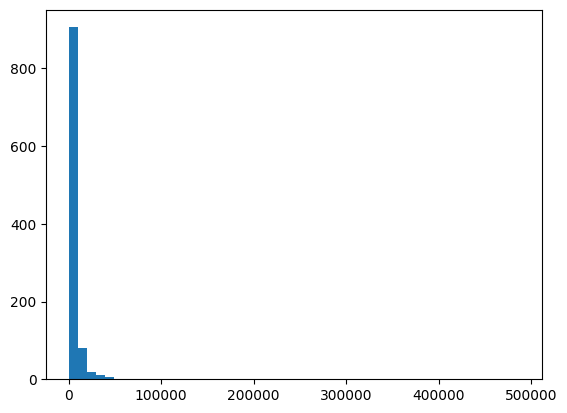

In [100]:
plt.hist(oversampled_trainX.iloc[:,0], bins=50)

In [218]:
model = LogisticRegression(max_iter=1000)

In [211]:
model.fit(oversampled_trainX, oversampled_trainY)

LogisticRegression(max_iter=1000)

In [212]:
model.score(X_test, y_test)

0.8246753246753247

In [215]:
y_pred=model.predict(X_test)

In [216]:
recall_score(y_test, y_pred)

0.9323308270676691

In [220]:
cv_score = cross_val_score(model, oversampled_trainX, oversampled_trainY, cv=5)

In [221]:
cv_score.mean()

0.930350358801182

In [87]:
model2 = SVC()

In [88]:
cv_score_svc = cross_val_score(model2, oversampled_trainX, oversampled_trainY, cv=5, scoring="recall")

In [89]:
cv_score_svc.mean()

0.5607169529499627

In [226]:
cv_score_svc.mean()

0.9835748792270532

In [228]:
model2.fit(oversampled_trainX, oversampled_trainY)

SVC()

In [229]:
model2.score(X_test, y_test)

0.8636363636363636

In [230]:
y_pred2 = model2.predict(X_test)

In [231]:
recall_score(y_test, y_pred2)

1.0

In [232]:
precision_score(y_test, y_pred2)

0.8636363636363636

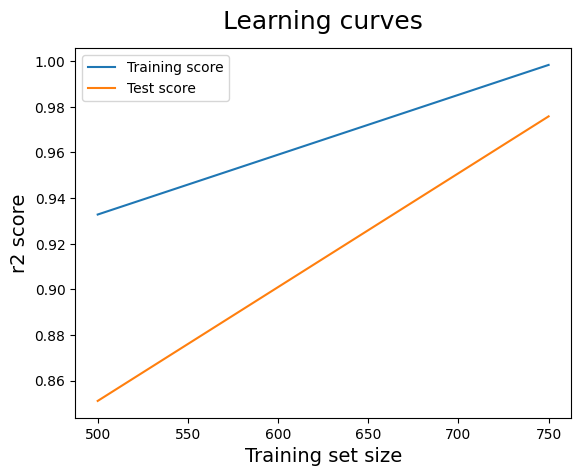

In [234]:
from sklearn.model_selection import learning_curve

train_sizes = [25,50,75,100,250,500,750]
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model2, X=oversampled_trainX, y=oversampled_trainY, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

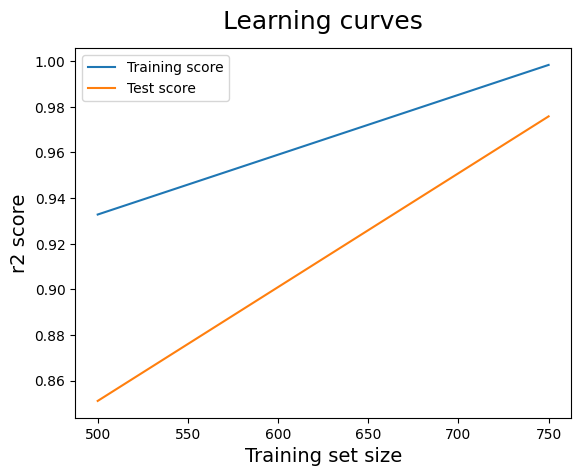

In [236]:
train_sizes = [25,50,75,100,250,500,750]
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model2, X=oversampled_trainX, y=oversampled_trainY, train_sizes=train_sizes, cv=5, scoring="accuracy")

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

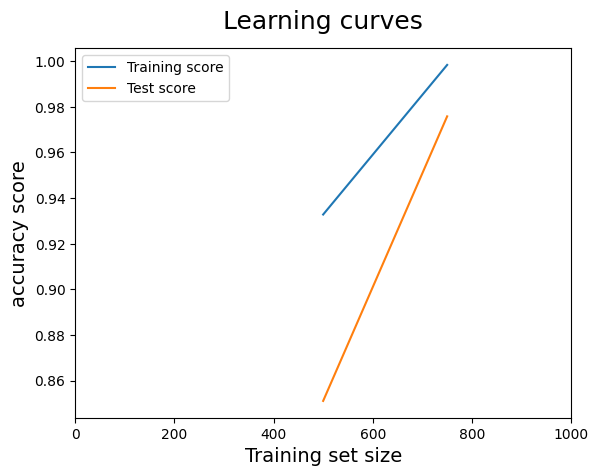

In [239]:
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize = 14)
plt.xlim(0,1000)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

## Power domain